# Deep Convolutional GAN with PyTorch

Implementation of the DCGAN architecture from scrath with PyTorch and training it on the [frog dataset](https://github.com/jonshamir/frog-dataset)

References:
- [Original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf)
- [PyTorch DCGAN tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
- [deeplearing.ai course](https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans/home/week/2)

In [1]:
# mount gdrive to save models
from pathlib import Path
from google.colab import drive

drive.mount('/content/gdrive')

Path("gdrive/MyDrive/frog-gan").mkdir(parents=True, exist_ok=True)

GDRIVE = '/content/gdrive/MyDrive/frog-gan'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
from IPython.display import clear_output
import pickle
import seaborn as sns
sns.set_style('whitegrid')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

def prepare_tensor_grid(image_tensor, num_images=25):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=int(num_images**0.5), padding=1)
    return image_grid.permute(1, 2, 0).squeeze()

def show_tensor_images(image_tensor, num_images=25, ax=None):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_grid = prepare_tensor_grid(image_tensor, num_images)
    if ax is None:
        ax = plt
    ax.imshow(image_grid)
    ax.axis('off')

Device: cuda:0


# Data Loading

In [3]:
# load the frog dataset
!git clone https://github.com/jonshamir/frog-dataset.git /content/data

Cloning into '/content/data'...
remote: Enumerating objects: 53349, done.
remote: Total 53349 (delta 0), reused 0 (delta 0), pack-reused 53349
Receiving objects: 100% (53349/53349), 1.02 GiB | 26.12 MiB/s, done.
Resolving deltas: 100% (113/113), done.
Checking out files: 100% (23392/23392), done.


In [4]:
class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform=None):
        self.image_paths = glob.glob(path + '*.png')
        self.transform = transform

    def __getitem__(self, index):
        x = Image.open(self.image_paths[index])
        # remove alpha channel
        background = Image.new('RGBA', x.size, (255,255,255))
        x = Image.alpha_composite(background, x)
        x = x.convert('RGB')

        if self.transform is not None:
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.image_paths)

In [5]:
TRAIN_DATA_PATH = '/content/data/data-64/'
BATCH_SIZE = 64

TRANSFORM_IMG = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.RandomRotation(20, fill=1),
    transforms.RandomHorizontalFlip()
    ])

In [6]:
train_data = UnlabeledDataset(path=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

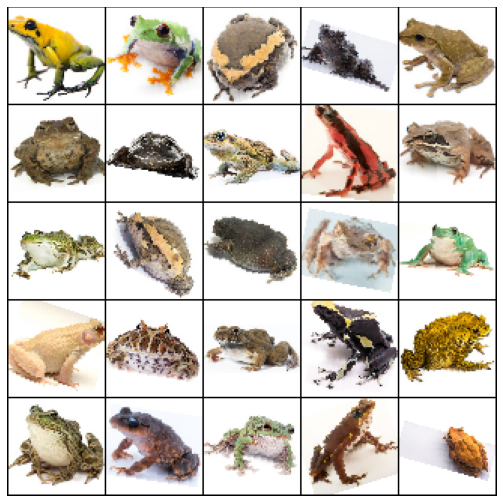

In [7]:
plt.subplots(figsize=(9, 9))
i = next(iter(train_loader))
show_tensor_images(i[0:25]);

# Models

In [8]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input is (im_chan) x 64 x 64
            nn.Conv2d(im_chan, hidden_dim, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (hidden_dim) x 32 x 32
            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (hidden_dim*2) x 16 x 16
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (hidden_dim*4) x 8 x 8
            nn.Conv2d(hidden_dim * 4, hidden_dim * 8, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (hidden_dim*8) x 4 x 4
            nn.Conv2d(hidden_dim * 8, 1, kernel_size=4,
                      stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.disc(input)

In [9]:
class Generator(nn.Module):

    def __init__(self, z_dim=100, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( z_dim, hidden_dim * 8, kernel_size=4,
                               stride=1, padding=0, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.ReLU(True),

            # state size. (hidden_dim*8) x 4 x 4
            nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(True),

            # state size. (hidden_dim*4) x 8 x 8
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),

            # state size. (hidden_dim*2) x 16 x 16
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),

            # state size. (hidden_dim) x 32 x 32
            nn.ConvTranspose2d(hidden_dim, im_chan, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size. (im_chan) x 64 x 64
        )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# GAN

In [11]:
ndf = 64
ngf = 64

criterion = nn.BCELoss()
z_dim = 100

lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999

fixed_noise = torch.randn(9, z_dim, device=device)

REAL_LABEL = 1.
FAKE_LABEL = 0.

In [12]:
discriminator = Discriminator(hidden_dim=ndf).to(device)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta_1, beta_2))
print(discriminator)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [13]:
generator = Generator(hidden_dim=ngf, z_dim=z_dim).to(device)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, beta_2))
print(generator)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Training

In [14]:
RESTORE = 400

if RESTORE is None or RESTORE == 0:
    img_list = []
    G_losses = []
    D_losses = []
    initial_epoch = 0

    discriminator.apply(weights_init)
    generator.apply(weights_init)
else:
    restore_path = GDRIVE+f'/checkpoint-{RESTORE}/'
    checkpoint = torch.load(restore_path+'torch_checkpoint')

    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    
    generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
    discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])

    generator.train()
    discriminator.train()

    G_losses = checkpoint['G_losses']
    D_losses = checkpoint['D_losses']
    fixed_noise = checkpoint['fixed_noise'].to(device)

    with open(restore_path+'img_list.pickle', 'rb') as f:
        img_list = pickle.load(f)
    initial_epoch = RESTORE
    print('Restored from '+restore_path)

Restored from /content/gdrive/MyDrive/frog-gan/checkpoint-400/


In [15]:
# Training Loop
NUM_EPOCHS = 1000
DISPLAY_STEP = 10
CHECKPOINT_STEP = 200

print("Starting Training Loop...")
# For each epoch
for epoch in range(initial_epoch+1, NUM_EPOCHS+1):
    print(f'Epoch: {epoch}')
    for i, data in enumerate(tqdm(train_loader)):
        # (1) Update discriminator
        discriminator.zero_grad()

        ## Train with all-real batch
        real = data.to(device)
        batch_size = real.size(0)

        output = discriminator(real)#.view(-1)
        label = torch.full_like(output, REAL_LABEL)
        discriminator_real_loss = criterion(output, label)
        
        ## Train with all-fake batch
        noise = torch.randn(batch_size, z_dim, device=device)
        fake = generator(noise)
        fake = fake.detach()
        output = discriminator(fake)#.view(-1)
        label = torch.full_like(output, FAKE_LABEL)
        discriminator_fake_loss = criterion(output, label)

        discriminator_loss = (discriminator_real_loss + discriminator_fake_loss) / 2
        discriminator_loss.backward()
        
        discriminator_optimizer.step()

        # (2) Update generator
        generator.zero_grad()
        fake = generator(noise)
        output = discriminator(fake)#.view(-1)
        label = torch.full_like(output, REAL_LABEL)
        generator_loss = criterion(output, label)
        generator_loss.backward()
        generator_optimizer.step()

        # Save Losses for plotting later
        G_losses.append(generator_loss.item())
        D_losses.append(discriminator_loss.item())

        # Output training stats and
        # check how the generator is doing by saving G's output on fixed_noise
        if i == len(train_loader)-1:

            print(f'real_loss {discriminator_real_loss.item()}\t fake_loss {discriminator_fake_loss.item()}')
            print(f'Loss_D: {D_losses[-1]:.4f}\tLoss_G: {G_losses[-1]:.4f}')
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(prepare_tensor_grid(fake, 9))

    if epoch % DISPLAY_STEP == 0:
        # clear_output()
        plt.imshow(img_list[-1])
        plt.axis('off')
        plt.title(f'epoch {epoch}')
        plt.show()

    if (epoch%CHECKPOINT_STEP == 0 and epoch > 0) or epoch == NUM_EPOCHS:
        path = GDRIVE+f'/checkpoint-{epoch}/'
        Path(path).mkdir(parents=True, exist_ok=True)
        torch.save({
            'epoch': epoch,
            'discriminator_state_dict': discriminator.state_dict(),
            'discriminator_optimizer_state_dict': discriminator_optimizer.state_dict(),
            'generator_state_dict': generator.state_dict(),
            'generator_optimizer_state_dict': generator_optimizer.state_dict(),
            'G_losses': G_losses,
            'D_losses': D_losses,
            'fixed_noise': fixed_noise
            }, path+"torch_checkpoint")
        with open(path+'img_list.pickle', 'wb') as f:
            pickle.dump(img_list, f)
        clear_output()
        print("Saved!")


Saved!


# Results

In [16]:
RESTORE = 800

restore_path = GDRIVE+f'/checkpoint-{RESTORE}/'
checkpoint = torch.load(restore_path+'torch_checkpoint')

generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

generator.eval()
discriminator.eval()

G_losses = checkpoint['G_losses']
D_losses = checkpoint['D_losses']

print('Restored from '+restore_path)

Restored from /content/gdrive/MyDrive/frog-gan/checkpoint-800/


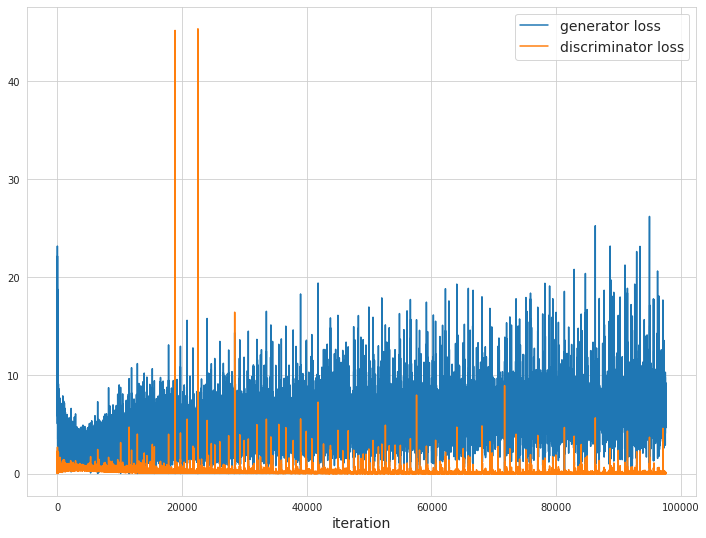

In [17]:
plt.subplots(figsize=(12, 9))
plt.plot(G_losses, label='generator loss')
plt.plot(D_losses, label='discriminator loss')
plt.xlabel('iteration', fontsize=14)
plt.legend(fontsize=14);

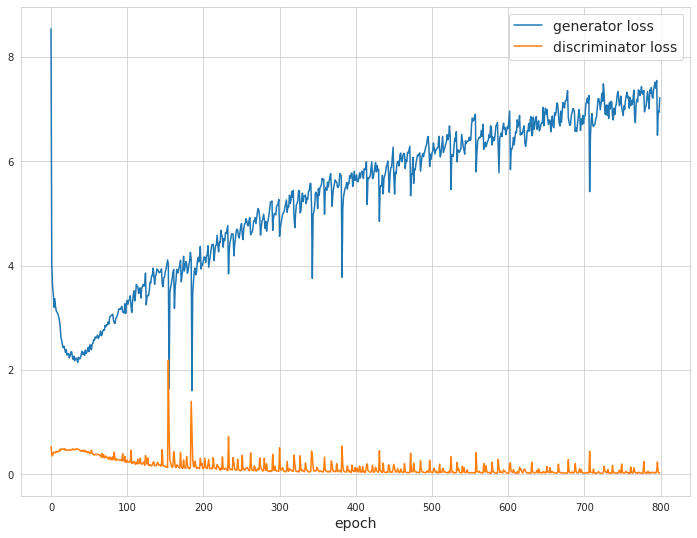

In [18]:
D_epoch_losses = np.array(D_losses).reshape(-1, 122).mean(axis=1)
G_epoch_losses = np.array(G_losses).reshape(-1, 122).mean(axis=1)

plt.subplots(figsize=(12, 9))
plt.plot(G_epoch_losses, label='generator loss')
plt.plot(D_epoch_losses, label='discriminator loss')
plt.xlabel('epoch', fontsize=14)
plt.legend(fontsize=14);

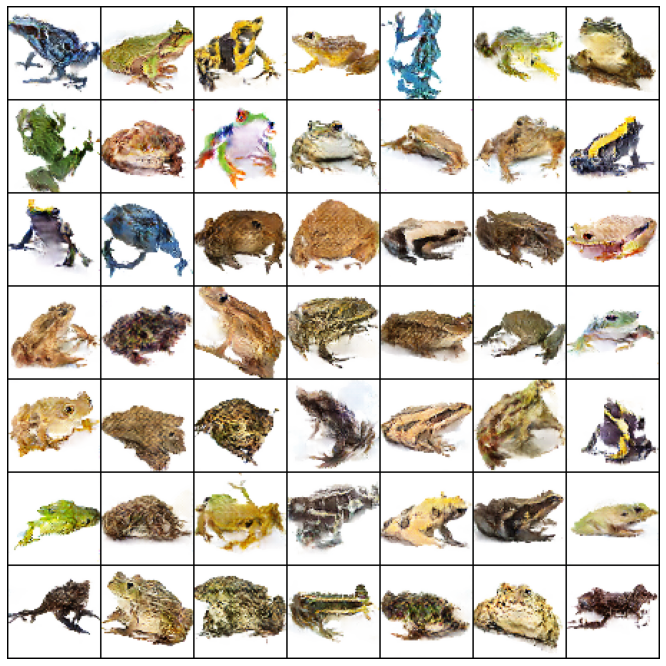

In [19]:
noise = torch.randn(49, z_dim, device=device)
image_tensor = generator(noise)

plt.subplots(figsize=(12, 12))
show_tensor_images(image_tensor, num_images=49)

Actually, some of them are not a frog. In the generator output, nice frogs are mixed with really distorted ones.

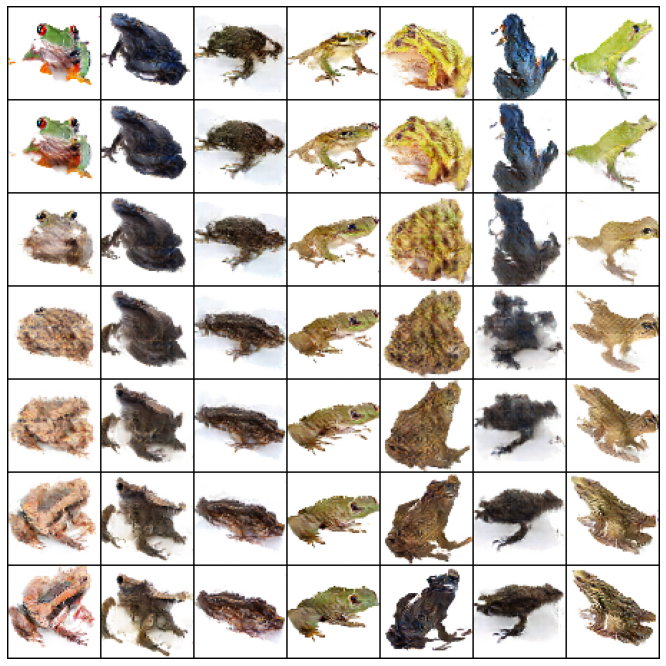

In [20]:
import numpy as np

frog1 = torch.randn(7, z_dim, device=device)
frog2 = torch.randn(7, z_dim, device=device)

T = torch.vstack([frog1*a + frog2*(1-a) for a in np.linspace(0,1,7)])
with torch.no_grad():
    image_tensor = generator(T)

plt.subplots(figsize=(12, 12))
show_tensor_images(image_tensor, num_images=49)

Some of latent space vector produces very random images.

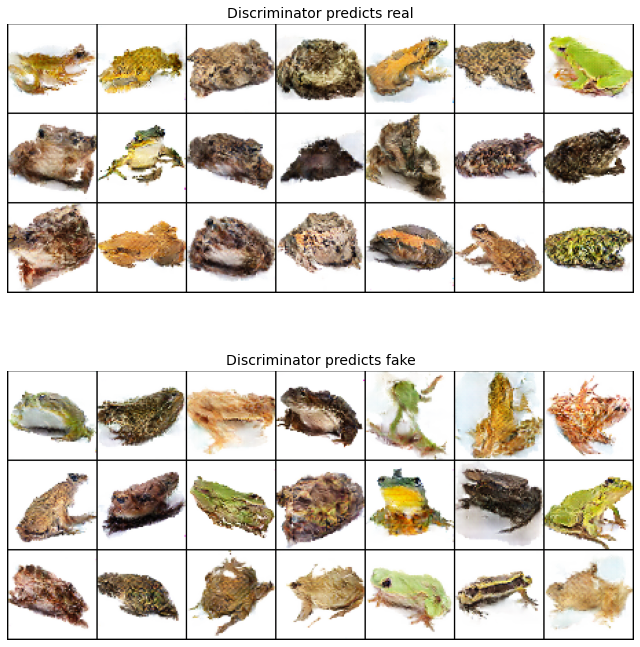

In [21]:
frogs = []
pseudofrogs = []
frogs_num = 21

while len(frogs) < frogs_num or len(pseudofrogs) < frogs_num:
    noise = torch.randn(1, z_dim, device=device)
    img = generator(noise)
    if discriminator(img) > 0.5 and len(frogs) < frogs_num:
        frogs.append(img)
    if discriminator(img) < 0.5 and len(pseudofrogs) < frogs_num:
        pseudofrogs.append(img)

fig, ax = plt.subplots(2, 1, figsize=(9, 10))
ax[0].set_title('Discriminator predicts real', fontsize=14)
show_tensor_images(torch.vstack(frogs), num_images=49, ax=ax[0])
ax[1].set_title('Discriminator predicts fake', fontsize=14)
show_tensor_images(torch.vstack(pseudofrogs), num_images=49, ax=ax[1])
plt.tight_layout()

# Summary
As we can see: Discriminator is not trained well, some of the well-looking images were classified as fake, while some of the blurry ones were classified as real.

But its loss fluctuates around zero, it had fitted to classify using some other features rather than similarity to a frog.

We can make a conclusion, that discriminator is a bottleneck of our GAN, and its problems are not architecture related, because attempts to reduce the number of its filters have worsened the result, and, as we know same architecture works well in the original paper.

Most likely, problems come from a small amount of training data and it poor preprocessing, I suppose that additional edges smoothing and denoising of the dataset can improve the quality of the model.

In [22]:
torch.save(generator.state_dict(), GDRIVE+'/frog-gan-v1.pt')